In [1]:
import sys
from pathlib import Path
import os
absolute_path = os.fspath(Path.cwd().parent)
if absolute_path not in sys.path:
    sys.path.append(absolute_path)

import random
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


from src.main.plot.figures import *

In [2]:
tx_chain = 'eth_polygon' 
p = 1 # ratio of data

In [3]:
relative_path_to_data = os.path.join('data','features') 
relative_path_to_data = os.path.join(relative_path_to_data, tx_chain) 
path_to_data = os.path.join(absolute_path, relative_path_to_data) 
files = os.listdir(path_to_data)
print(path_to_data)

d:\Perso\Gitcoin\Hackathon_open_data\data\features\eth_polygon


In [4]:
df_eth = pd.read_csv(os.path.join(path_to_data, files[0]), index_col=0, skiprows=lambda i: i>0 and random.random() > p)
print(df_eth.shape)
df_eth.head(2)

(8227, 164)


,countUniqueInteracted,ratioUniqueInteracted,countTx,outgoing,outgoingRatio,gas__approximate_entropy__m_2__r_0.1,gas__approximate_entropy__m_2__r_0.3,gas__approximate_entropy__m_2__r_0.5,gas__approximate_entropy__m_2__r_0.7,gas__approximate_entropy__m_2__r_0.9,...,value__variation_coefficient,value__percentage_of_reoccurring_datapoints_to_all_datapoints,value__percentage_of_reoccurring_values_to_all_values,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__ratio_beyond_r_sigma__r_1,value__ratio_beyond_r_sigma__r_2,value__ratio_beyond_r_sigma__r_6,value__ratio_value_number_to_time_series_length
address,,,,,,,,,,,,,,,,,,,,,
0x0000ce08fa224696a819877070bf378e8b131acf,338.0,0.158984,2126,2095,0.985419,1.571569,1.123299,0.802094,0.591663,0.448746,...,13.206278,0.965663,0.231579,0.479086,0.749410,1.022944,0.015522,0.010348,0.002352,0.044685
0x000bec82c41837d974899b26b26f9cc8890af9ea,55.0,0.407407,135,129,0.955556,0.686538,0.974569,0.745694,0.596187,0.450037,...,2.933269,0.844444,0.250000,1.188265,1.806814,2.408489,0.088889,0.059259,0.007407,0.207407


In [5]:
df = df_eth
df.shape

(8227, 164)

In [6]:
#drop duplicate columns
df_dup = df.T.drop_duplicates().T
df_dup.shape

(8227, 156)

In [7]:
# drop 0 std
col_var = df_dup.columns[df_dup.std() <10E-20]
df_dup = df_dup.drop(columns=col_var)
print(df_dup.shape)

(8227, 155)


In [8]:
# we note that outgoing is highly correlated with countTx, so we create a new column with incomming
# # note we already created ratio that is not correlated 
df_dup['incomming'] = df_dup['countTx'] - df_dup['outgoing'] 
df['incomming'] = df['countTx'] - df['outgoing'] 

In [9]:
X_train = df_dup.values
scaler = StandardScaler().fit(X_train)
print(scaler)

np_std = scaler.transform(X_train)
df_std = pd.DataFrame(np_std, index=df_dup.index, columns=df_dup.columns)
df_std.shape

StandardScaler()


(8227, 156)

In [10]:
corr_pearson = df_std.corr(method='pearson')
corr_value_max = 0.98
corr_column_high = []
corr_column_high_dict = {}
corr_columns = corr_pearson.columns
l_columns = (len(corr_columns))
for i_col in range (l_columns):
    for i_row in range (i_col + 1, l_columns):
        if (abs(corr_pearson.iloc[i_row, i_col]) > corr_value_max):  # type: ignore
            corr_column_high.append(corr_columns[i_row])
            corr_column_high_dict[corr_columns[i_row]] = corr_columns[i_col]

len(corr_column_high)
print(corr_column_high_dict)
print(corr_column_high)
df_uncorr = df_std.drop(columns=corr_column_high)
print("removed columns : ")
print(df_uncorr.shape)
np_uncorr = df_uncorr.values

{'outgoing': 'countTx', 'gas__count_below_mean': 'outgoing', 'gasPrice__count_below_mean': 'outgoing', 'value__count_below_mean': 'gasPrice__count_below_mean', 'gasPrice__standard_deviation': 'gasPrice__maximum', 'gasPrice__variance': 'gasPrice__standard_deviation', 'timeStamp__variation_coefficient': 'timeStamp__standard_deviation', 'value__mean': 'value__abs_energy', 'value__standard_deviation': 'value__mean_abs_change', 'value__variance': 'value__standard_deviation', 'value__mean_abs_change': 'value__mean'}
['outgoing', 'gas__count_below_mean', 'gasPrice__count_below_mean', 'value__count_below_mean', 'gas__count_below_mean', 'gasPrice__count_below_mean', 'value__count_below_mean', 'value__count_below_mean', 'value__count_below_mean', 'gasPrice__standard_deviation', 'gasPrice__variance', 'timeStamp__variation_coefficient', 'value__mean', 'value__standard_deviation', 'value__variance', 'value__mean_abs_change', 'value__standard_deviation', 'value__variance', 'value__standard_deviation

In [11]:
#Run kmeans first time
kmeans_results = []
min_cluster = 2
max_cluster = 16
for k in range (min_cluster, max_cluster+1):
    kmeans = KMeans(n_clusters=k)
    y_pred = kmeans.fit_predict(np_uncorr)
    kmeans_results.append(kmeans)

kmeans_inertia = [k.inertia_ for k in kmeans_results]


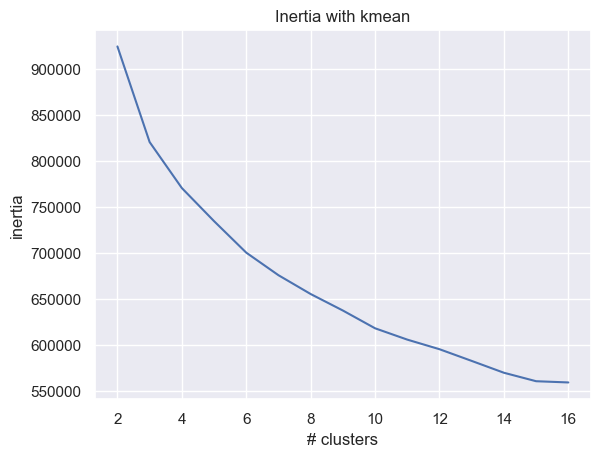

In [12]:
range_n_clusters = np.linspace(min_cluster, max_cluster, max_cluster-min_cluster+1)
ax = sns.lineplot(x=range_n_clusters, y=kmeans_inertia)
ax.set_title('Inertia with kmean')
ax.set_ylabel('inertia')
ax.set_xlabel('# clusters')

kmeans_silhouette = [silhouette_score(np_uncorr, k.labels_)  for k in kmeans_results]


We must have outliers thus creating additional cluster put these outliers into cluster decreasing the inertia globally

In [13]:
n_clusters = 15
df_occurences, cluster_labels = get_df_occurences(np_uncorr, kmeans_results, n_clusters, min_cluster)
print(df_occurences)

    occurences  percentage
3         1775   21.575301
1         1135   13.796037
4          916   11.134071
10         907   11.024675
12         686    8.338398
13         602    7.317370
7          526    6.393582
2          497    6.041084
5          484    5.883068
0          360    4.375836
6          229    2.783518
8           60    0.729306
14          48    0.583445
9            1    0.012155
11           1    0.012155


d:\Perso\Gitcoin\Hackathon_open_data\vGitcoinViz\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


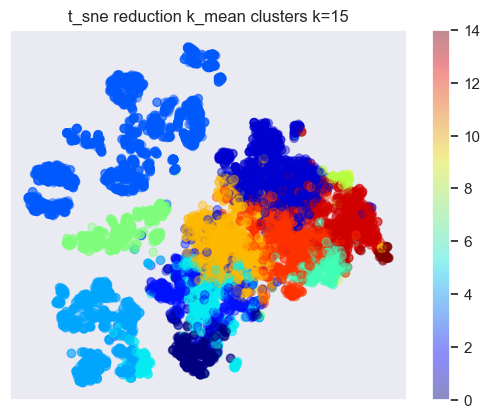

In [14]:
X_embedded_uncorr = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(np_uncorr)
# %%
scatter_plot_2d(X_embedded_uncorr, cluster_labels, 't_sne reduction k_mean clusters k={}'.format(n_clusters))


In [15]:
#remove outliers
df_small_cluster = df_occurences[df_occurences['percentage'] < 1]
cluster_to_drop = df_small_cluster.index.values
print(cluster_to_drop)
index_to_keep = [cl not in cluster_to_drop for cl in cluster_labels]

[ 8 14  9 11]


In [16]:
df_no_outliers = df_uncorr.iloc[index_to_keep,:]
print(df_no_outliers.shape)
df_no_outliers_not_normalized = df.loc[index_to_keep,df_no_outliers.columns]  # type: ignore

(8117, 145)


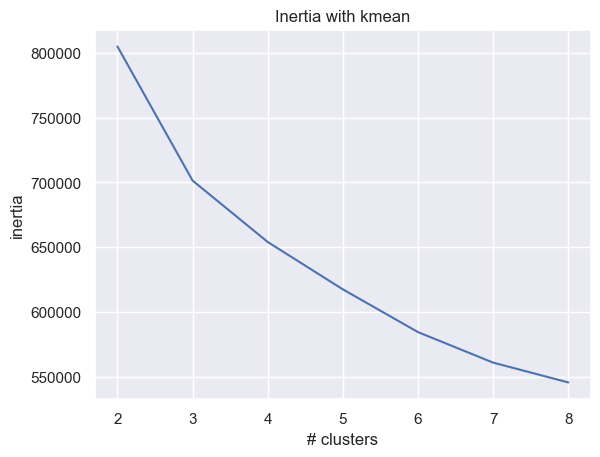

In [17]:
#run k_mean again without outliers
np_no_outliers = df_no_outliers.to_numpy()
kmeans_results = []
min_cluster = 2
max_cluster = 8
for k in range (min_cluster, max_cluster+1):
    kmeans = KMeans(n_clusters=k)
    y_pred = kmeans.fit_predict(np_no_outliers)
    kmeans_results.append(kmeans)

kmeans_inertia = [k.inertia_ for k in kmeans_results]

range_n_clusters = np.linspace(min_cluster,max_cluster,max_cluster-min_cluster+1)
ax = sns.lineplot(x=range_n_clusters, y=kmeans_inertia)
ax.set_title('Inertia with kmean')
ax.set_ylabel('inertia')
ax.set_xlabel('# clusters')

kmeans_silhouette = [silhouette_score(np_no_outliers, k.labels_)  for k in kmeans_results]

In [18]:
X_embedded_no_outliers = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(np_no_outliers)

d:\Perso\Gitcoin\Hackathon_open_data\vGitcoinViz\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.25279672086363064
   occurences  percentage
1        4486   55.266724
0        3631   44.733276


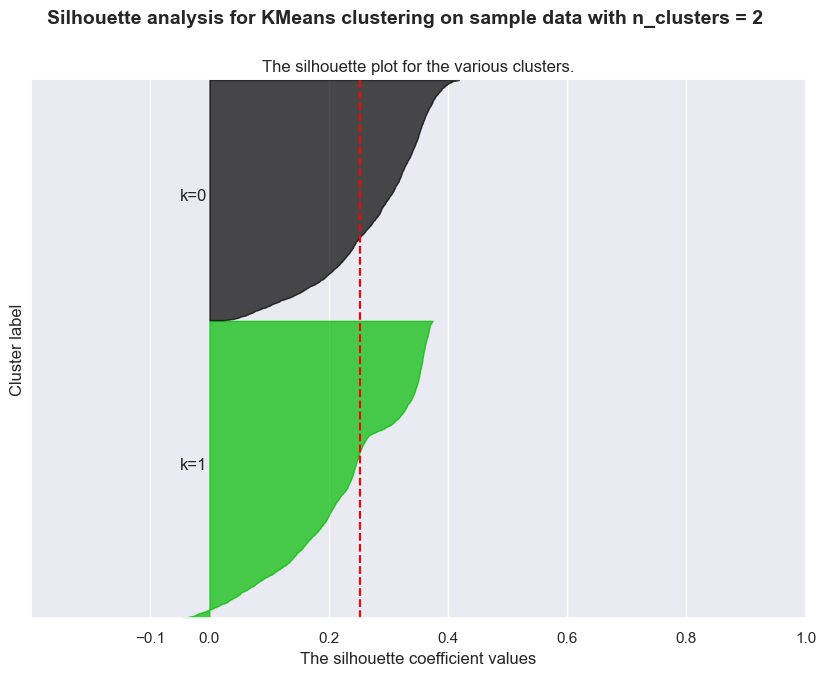

   occurences  percentage
1        4486   55.266724
0        3631   44.733276


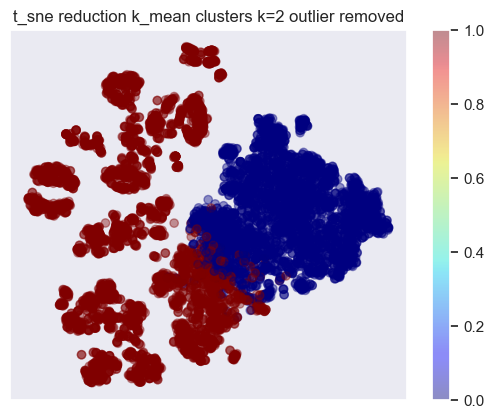

d:\Perso\Gitcoin\Hackathon_open_data\src\main\plot\figures.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = cluster_labels


k=2, cluster = 1
Index(['0x3ae7783b7fa466e2c9197e60c05c84d6683cbc53',
       '0xa65d6996fb3b5d2cd311a3063fa6977412036d87',
       '0xe5bfca79a847873a123d196a02aaf3b10cbcadd2',
       '0xc9a7c79a6be4f5e7f531414ce608c0d077d79ae6'],
      dtype='object', name='address')
k=2, cluster = 0
Index(['0x40c6ac083cbf836d622fe9e7679b9dea76235adf',
       '0x55b2f6252f1c2d658e723f7c73f48b53cd434fa3',
       '0xe422a8432fa9d6f3874d1c61c0ae9cd9b4b628c0',
       '0xe673979e3a15c6d915e0e9b21209f0ca6427956b'],
      dtype='object', name='address')
For n_clusters = 3 The average silhouette_score is : 0.25940866931361006
   occurences  percentage
2        3358   41.369964
0        2458   30.282124
1        2301   28.347912


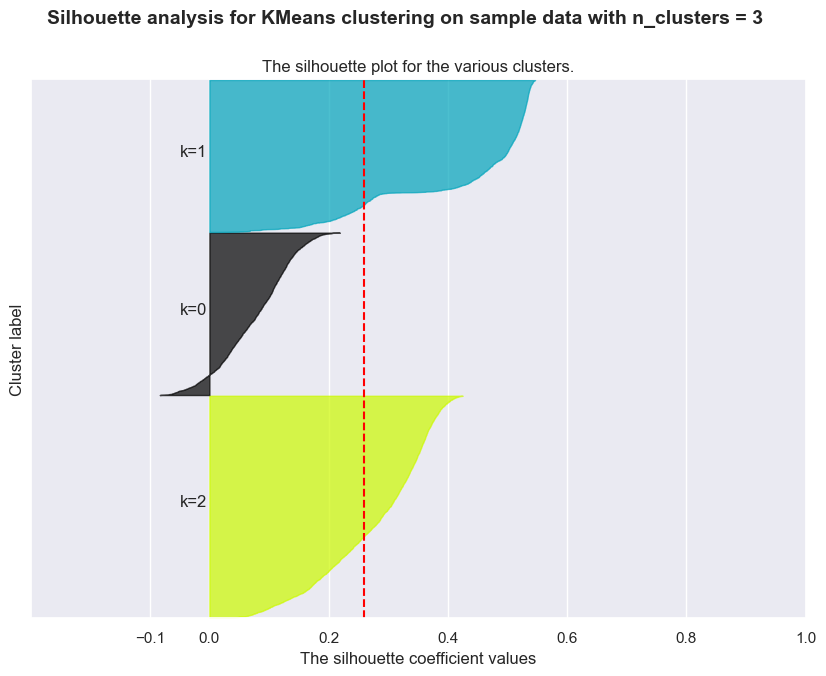

   occurences  percentage
2        3358   41.369964
0        2458   30.282124
1        2301   28.347912


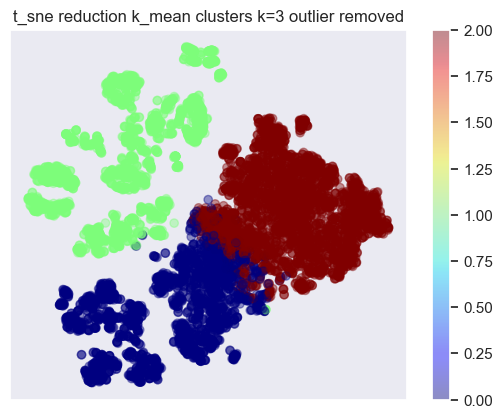

d:\Perso\Gitcoin\Hackathon_open_data\src\main\plot\figures.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = cluster_labels


k=3, cluster = 2
Index(['0x422fc6d98bfc720be3b9c594a324dbdce79c9967',
       '0xaa2427f5278b759bb66c0ec7bdd4ee0f3b7697ec',
       '0x53d09055e5b96b676816b1bcbbc20ff00df6f8ab',
       '0xa884a2f1a5ec6c2e499644666a5e6ef97b988888'],
      dtype='object', name='address')
k=3, cluster = 0
Index(['0xf7a584c2973730973574e04f0a1cd42e87d28c4c',
       '0x3a53c4d69942be0d49e871e515c602bcf98b3aa1',
       '0xe6b9981b1bd98754109d7c08d503ba7a05f1df50',
       '0xd200954dee66e84bb9bc70cdd63dbe030932119c'],
      dtype='object', name='address')
k=3, cluster = 1
Index(['0x22d9524b670d08c93cdc36b95aa30e2f8f4b254e',
       '0x71c4bd284a68fa4a6a4bf9dbfb5487fe46e3f038',
       '0xef7f8943bd02f2491222c9f97243b32a2fa95381',
       '0x0b187ccef010ef72d5ba62cba3264c90f5b6ed37'],
      dtype='object', name='address')
For n_clusters = 4 The average silhouette_score is : 0.2373661235417608
   occurences  percentage
0        2608   32.130097
2        2301   28.347912
3        1798   22.151041
1        1410   17.3

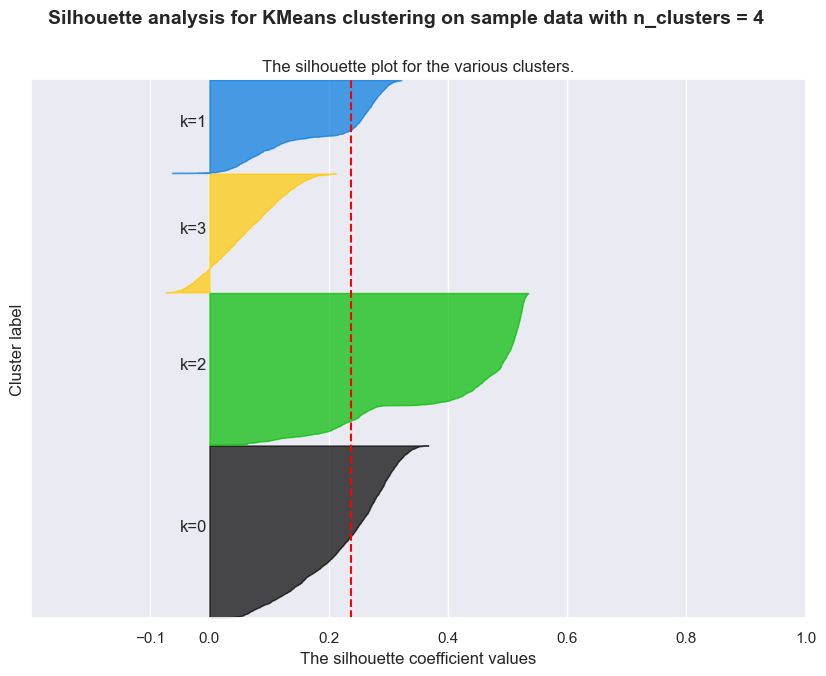

   occurences  percentage
0        2608   32.130097
2        2301   28.347912
3        1798   22.151041
1        1410   17.370950


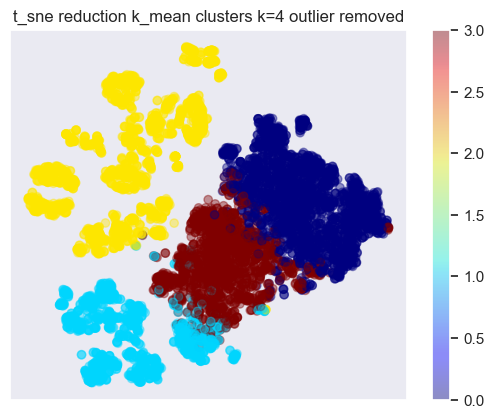

d:\Perso\Gitcoin\Hackathon_open_data\src\main\plot\figures.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = cluster_labels


k=4, cluster = 0
Index(['0x464985b2e3e80f2f3152266e4b339cd4ca6670df',
       '0x3ca524f1a819dcb8e46155347155d7e5b8ee2620',
       '0xbfe7340cc139dd77313dcf2beb4374ad7e1c8345',
       '0x83f68939de5b679299de9d72b40a6e4688b6c587'],
      dtype='object', name='address')
k=4, cluster = 2
Index(['0xbc008fa288e4eaa7f490ae13da44499c7ad10241',
       '0xcf35cfacf4f2ce74556064d51d5405e58be327f4',
       '0x84c1c6dc90981e77770665dd993659621fcf52a9',
       '0xa15e60154bb72451a2b49343080a5b15d622e3bb'],
      dtype='object', name='address')
k=4, cluster = 3
Index(['0x6793af1b83d748cc7b0fe3f7cd4438e2904b7ee5',
       '0x02bbeb65ffcb7f60840bdd3b5dfb907e21264f37',
       '0xbfea3e1a216ccff9720e6268ddc8bd98963bdcde',
       '0x8a28c690d0c3abca62924a2b6940c33f42f5bca3'],
      dtype='object', name='address')
k=4, cluster = 1
Index(['0xccf673e154eb8692dd8e8518c498f84739462f9d',
       '0x5073094172337b26fb5b87d15e8f40468bbfe223',
       '0x2ca684a8c28be1913ee8f69c8763a6eb9e342656',
       '0x6a00a4d008

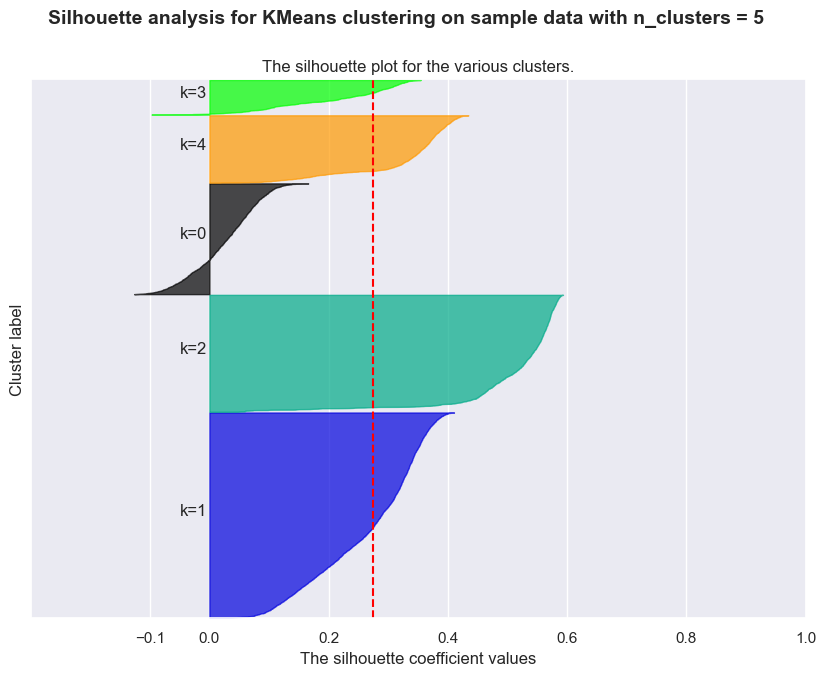

   occurences  percentage
1        3112   38.339288
2        1775   21.867685
0        1681   20.709622
4        1023   12.603179
3         526    6.480227


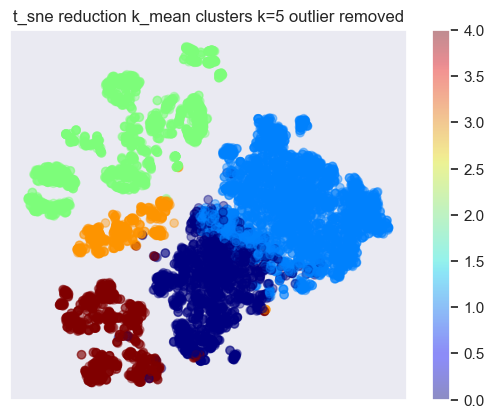

k=5, cluster = 1
Index(['0x3880826a1a8beeee59fe14ada5cf7347c2bf961f',
       '0xea49b3b50fca562b651c4192eb8119855b6dd6e8',
       '0x69e9288e713c1f7325c48d70704f04b3f5b51a65',
       '0x59499e6015517b28f2279ddf3724b745679eafd7'],
      dtype='object', name='address')
k=5, cluster = 2
Index(['0x6109276a1093e6dcb3ca5518c321623b8b4c1f01',
       '0x7a37ad6540407730460eae225fbfbd01d134b745',
       '0xbd8f3d9050fc15e3fc2e6eeb3dd45c05b9228df0',
       '0x3d4a7860dd05f870620fa4cdca3c019a805173f7'],
      dtype='object', name='address')
k=5, cluster = 0
Index(['0x46101fcb41ab3e63ff9532ccd7e991eb43093994',
       '0x84d236675e513471d6f5cbd8bc4ff70175686925',
       '0xba7e3407877dfa4a6e19a263b399b545941ebf2d',
       '0x70ff79f948c56bc3e1384760d9d160b5007c9e5a'],
      dtype='object', name='address')
k=5, cluster = 4
Index(['0xab3d66d5ee4f91208e0aaa633cf308872f66d934',
       '0x94c08644a360b4d11ccf0c79ee37f72798888888',
       '0x923c0bc1a01f64a8917164560815d0b48ba0f1d7',
       '0x8d18b914e6

d:\Perso\Gitcoin\Hackathon_open_data\src\main\plot\figures.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = cluster_labels


   occurences  percentage
1        2283   28.126155
0        1775   21.867685
2        1422   17.518788
4        1095   13.490206
3        1016   12.516940
5         526    6.480227


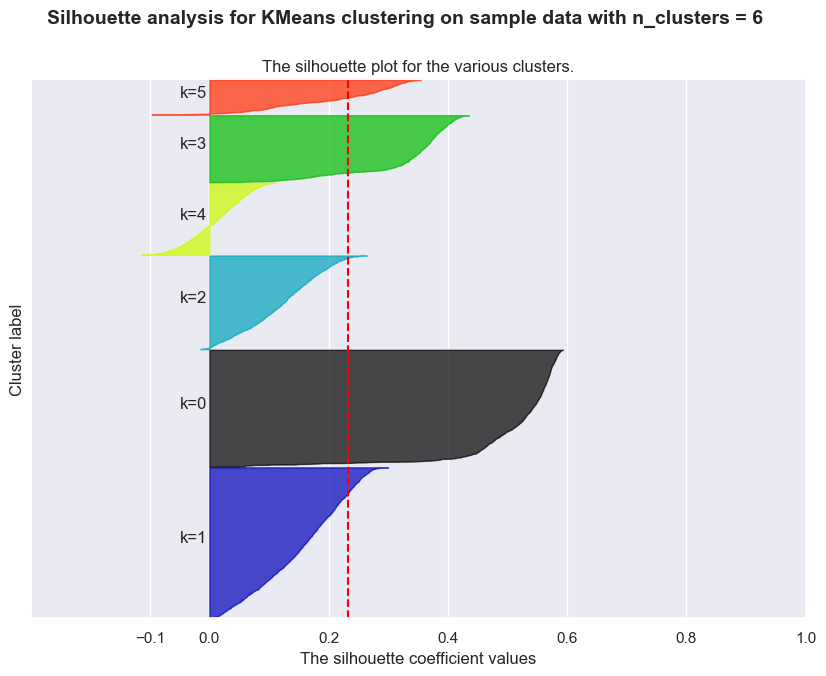

   occurences  percentage
1        2283   28.126155
0        1775   21.867685
2        1422   17.518788
4        1095   13.490206
3        1016   12.516940
5         526    6.480227


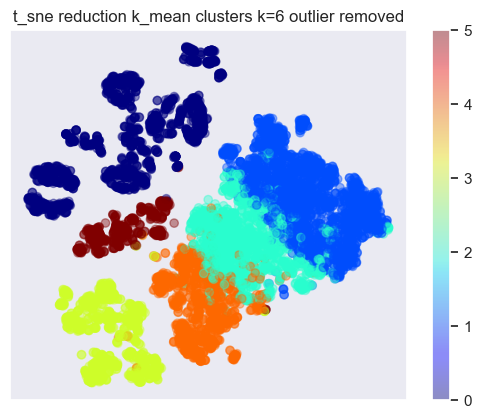

k=6, cluster = 1
Index(['0x1ee492e83739eff40ebca92fdf09404619e80d81',
       '0xd8d3de09e13214032bcce2b2cd266ab80ad2624d',
       '0x478c9bef4702ca6758f3ed760a51677f74813df5',
       '0x65d33f43acd24ecb49361eaee7fdd27ecdf193d4'],
      dtype='object', name='address')
k=6, cluster = 0
Index(['0x42fc62b9e79209b74ef9ee746498242a572e174d',
       '0x6eaf59490ecf357e11ec5a68234e0385e35cf872',
       '0xc41a6568889fd2017650efcb959653a55a46018b',
       '0xe1f3b73508cbba08343da2ea1fee3ae536d78e11'],
      dtype='object', name='address')
k=6, cluster = 2
Index(['0x621278c9cfaed37e650619a4a3629523b3ec737e',
       '0x1eb26449013180ba1060389a0cd08a3c05ddc54c',
       '0x85088640cfa11614300374a78eccf634061e003c',
       '0x3cad756e4c16a6b782e5a50bdd8097113f2d26f8'],
      dtype='object', name='address')
k=6, cluster = 4
Index(['0x5a61bc171ceaa39cb84d00bee28a5806d0165ec2',
       '0xe7216c4dee53ff02286db4fe3f632c3cb4645a7e',
       '0x17012ba67a5470e2977f3beee99e37e779f20782',
       '0x387028e8d4

d:\Perso\Gitcoin\Hackathon_open_data\src\main\plot\figures.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = cluster_labels


   occurences  percentage
0        1777   21.892325
2        1775   21.867685
1        1296   15.966490
5        1064   13.108291
3        1016   12.516940
4         663    8.168042
6         526    6.480227


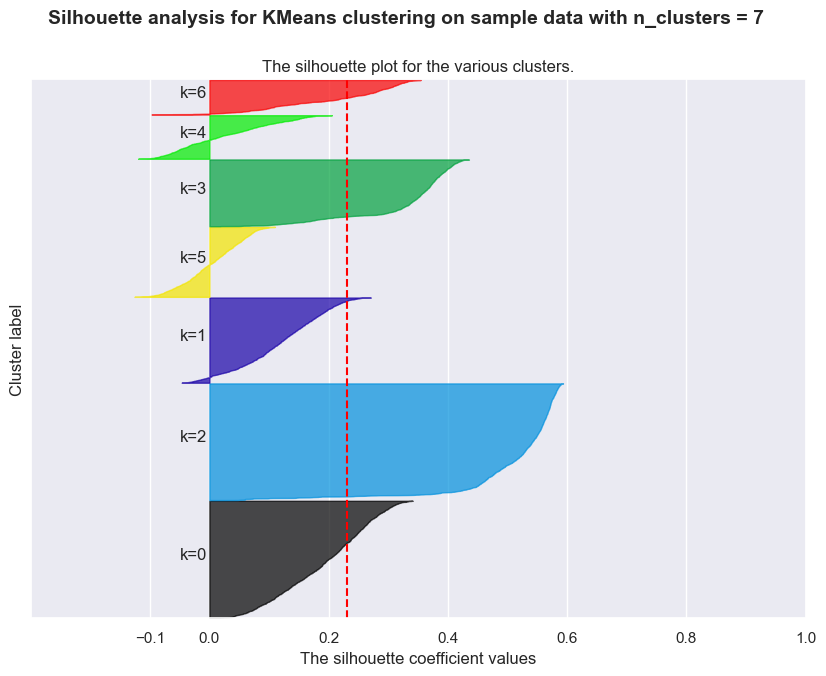

   occurences  percentage
0        1777   21.892325
2        1775   21.867685
1        1296   15.966490
5        1064   13.108291
3        1016   12.516940
4         663    8.168042
6         526    6.480227


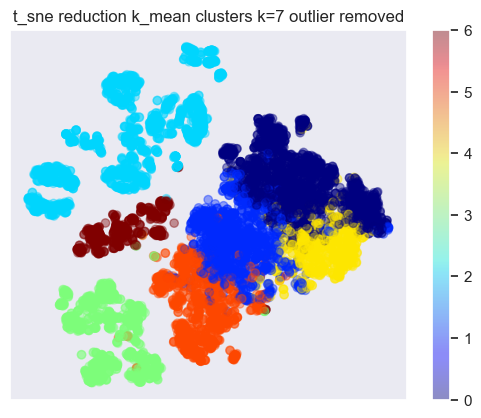

k=7, cluster = 0
Index(['0xccf673e154eb8692dd8e8518c498f84739462f9d',
       '0x3880826a1a8beeee59fe14ada5cf7347c2bf961f',
       '0x168407a4fb4ab7078761451d8660c3c93b8fefbf',
       '0x9b0b93abed876a207bd7f043b571d4e8f3be33a9'],
      dtype='object', name='address')
k=7, cluster = 2
Index(['0xd61767541c6da0c233fe728909ffe22ae75491ae',
       '0x1e6c3c2054ec6027b653715be963fed04b836501',
       '0x4ca2a670bd5505b870b21331a53d9bb4ae6e2084',
       '0x752434834ecd885b53a83de889f3638f69176521'],
      dtype='object', name='address')
k=7, cluster = 1
Index(['0xf6a48f4ea7c11cfd0100f2cbf7461cfca3f0e849',
       '0x1bf36ec9e8d8501bcff444238c4f4f56730de0e6',
       '0xaa33cfe65af99e87c0d89fb978ac9a2f4e09c270',
       '0x88fa395aa8a7b57cff6572fd37b585e1e8ce3dac'],
      dtype='object', name='address')
k=7, cluster = 5
Index(['0xcb29020109c1e4e0c07525fab62d639f1fdd111c',
       '0x1cff5ae2fd7b5cdd0977100c9e54ef585e1e9646',
       '0x40a4fce89b26e924a3b5f13a91e78a5dc4944a45',
       '0xbe00263b04

d:\Perso\Gitcoin\Hackathon_open_data\src\main\plot\figures.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = cluster_labels


   occurences  percentage
1        1775   21.867685
0        1397   17.210792
4        1156   14.241715
7        1041   12.824935
2        1016   12.516940
5         633    7.798448
6         573    7.059258
3         526    6.480227


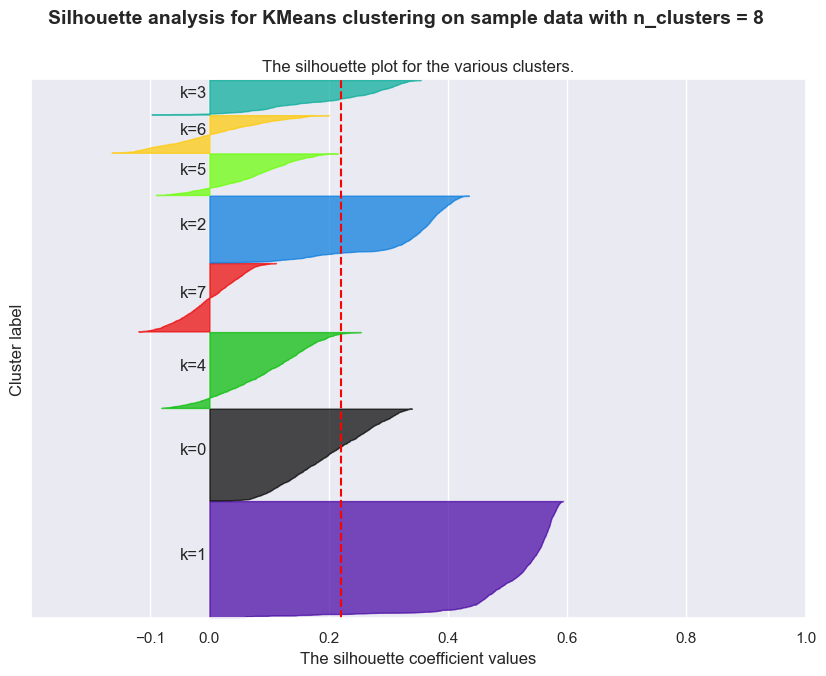

   occurences  percentage
1        1775   21.867685
0        1397   17.210792
4        1156   14.241715
7        1041   12.824935
2        1016   12.516940
5         633    7.798448
6         573    7.059258
3         526    6.480227


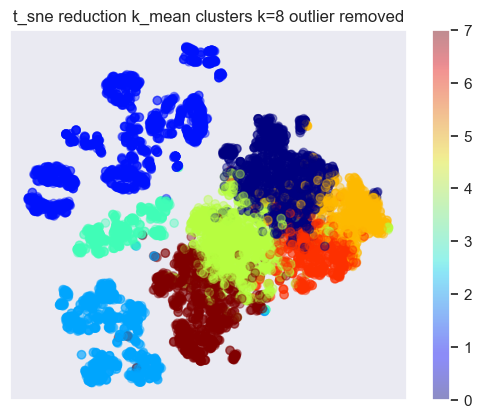

k=8, cluster = 1
Index(['0xc95c31967c4f4575f378a287fbe1a0893dbd2b9f',
       '0xa34b0e7c3f2540ba58be91c8758aa6798c6a9dac',
       '0xe14f03a3349cf7e1362b133e86853b4a2328a903',
       '0x304a7da2c2d2f82e591adea9807cfbd7ed1eab88'],
      dtype='object', name='address')
k=8, cluster = 0
Index(['0xfa77dac98e100ce4fe5290b489eac578b371e7a7',
       '0x32994f31fdd0ffcd94fb85c7952ab869ad4510ab',
       '0x0642785c9bd3a38ae1ea0a44f900e09c1e54534c',
       '0x39ea25c016a3e90e8e72dbbe215a1ab62429f66f'],
      dtype='object', name='address')
k=8, cluster = 4
Index(['0x9b0e7954e36f9262dde23f46624d746be965c234',
       '0x1a60a0ae5940b3740336fa72ae05012fa08613d9',
       '0x87e20e28ed7e2b97d81060111d1e6f722d181fa5',
       '0xa0439ee4a2951756f093f941fef2466fc771e874'],
      dtype='object', name='address')
k=8, cluster = 7
Index(['0x221d5d198f000695690809c10af4c6b8d9577726',
       '0x8c102040d0a9aedaef7c852571dcd0fdfb2e84e7',
       '0x2159bcb3839096791cefe0c95890de7d2f109324',
       '0xd2a42cea94

d:\Perso\Gitcoin\Hackathon_open_data\src\main\plot\figures.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = cluster_labels


In [19]:
plot_silhouette_tsne_save_hist(df_no_outliers, kmeans_results, kmeans_silhouette, min_cluster, max_cluster, X_embedded_no_outliers, absolute_path, tx_chain)

In [20]:
np_dataset = df_no_outliers_not_normalized.values
n_cluster = 4
    # for n_cluster in range (min_cluster, max_cluster+1):

df_occurences, cluster_labels = get_df_occurences(np_dataset, kmeans_results, n_cluster, min_cluster)

path_charts = os.path.join(absolute_path, "charts_kmean")
path_charts = os.path.join(path_charts, tx_chain)
path_charts = os.path.join(path_charts, "k={}".format(n_cluster))

df_no_outliers_not_normalized["cluster"] = cluster_labels

cluster_col_name = "cluster"   
cols = df_no_outliers_not_normalized.columns
debug = True

for i in range (0, len(cols)):
    i_col = cols[i]
    if i_col not in ["timeStamp__variance_larger_than_standard_deviation", "value__abs_energy"]: # cause bug out of memory!
        if debug:
            print(str(i) + " " + str(i_col))
            
        if cluster_col_name == None:
            sns_plot = sns.histplot(df_no_outliers_not_normalized, x=i_col)
        else:
            n_cluster = len(df_no_outliers_not_normalized[cluster_col_name].unique())
            sns_plot = sns.histplot(df_no_outliers_not_normalized, x=i_col, hue=cluster_col_name, palette=sns.color_palette('bright', n_colors=n_cluster))
        fig_name = str(i_col) + ".png"
        fig = sns_plot.get_figure()

        if not os.path.exists(path_charts):
            os.makedirs(path_charts)

        fig.savefig(os.path.join(path_charts, fig_name))
        fig.clf() 
        plt.close()
# save_hist(df_no_outliers_not_normalized, path_charts, cluster_col_name="cluster", debug=False)

0 countUniqueInteracted
1 ratioUniqueInteracted
2 countTx
3 outgoingRatio
4 gas__approximate_entropy__m_2__r_0.1
5 gas__approximate_entropy__m_2__r_0.3
6 gas__approximate_entropy__m_2__r_0.5
7 gas__approximate_entropy__m_2__r_0.7
8 gas__approximate_entropy__m_2__r_0.9
9 gas__autocorrelation__lag_1
10 gas__autocorrelation__lag_2
11 gas__autocorrelation__lag_3
12 gas__autocorrelation__lag_4
13 gas__benford_correlation
14 gas__binned_entropy__max_bins_5
15 gas__count_above_mean
16 gas__has_duplicate
17 gas__maximum
18 gas__mean
19 gas__mean_abs_change
20 gas__mean_change
21 gas__mean_second_derivative_central
22 gas__median
23 gas__minimum
24 gas__skewness
25 gas__standard_deviation
26 gas__variance
27 gas__variance_larger_than_standard_deviation
28 gas__variation_coefficient
29 gas__percentage_of_reoccurring_datapoints_to_all_datapoints
30 gas__percentage_of_reoccurring_values_to_all_values
31 gas__permutation_entropy__dimension_3__tau_1
32 gas__permutation_entropy__dimension_4__tau_1
33

In [21]:
# save_hist_clusters(df_no_outliers_not_normalized, kmeans_results, min_cluster, max_cluster ,absolute_path, tx_chain)